In [46]:
from FlowStorm.flow_surface import FlowSurface
from FlowStorm.toy_data import generate_discrete_dataset
from FlowStorm.yield_model import YieldModel_RBF, YieldModel_Poly

import jax.random as jr
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [ ]:
rng = jr.key(187)
N = 100_000
base_alpha = 0.
baseline_mu = 0.
baseline_data = generate_discrete_dataset(rng,base_alpha,sigma=1.,p=.5,n=N)
base_alphas = jnp.array([base_alpha]*N)

In [ ]:
off_baseline_ps = [.25,.33,.5,.67,.75]
off_baseline_sigma = 1.
off_baseline_mus = [-2.,-1.,0.,1.,2.]
off_baseline_sets = []
off_baseline_alphas = []
for off_baseline_p in off_baseline_ps:
    rng, subkey = jr.split(rng)
    data = generate_discrete_dataset(subkey, baseline_mu, off_baseline_sigma, off_baseline_p, N)
    alphas = jnp.array([baseline_mu]*len(data))[:,None]
    off_baseline_sets.append(data)
    off_baseline_alphas.append(alphas)

x_train = jnp.concatenate(off_baseline_sets)
alpha_train = jnp.concatenate(off_baseline_alphas)

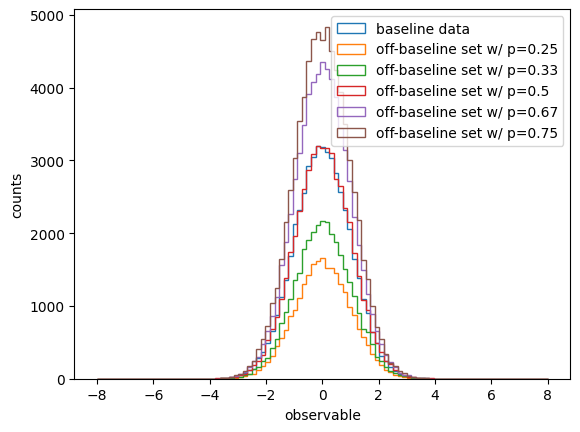

In [106]:
fig ,ax = plt.subplots()
bins = jnp.linspace(-8,8,100)
ax.hist(baseline_data,bins=bins,histtype="step",label="baseline data")
for i,goal_alpha in enumerate(off_baseline_ps):
    ax.hist(off_baseline_sets[i],bins=bins,histtype="step", label=f"off-baseline set w/ p={goal_alpha}")
ax.set_xlabel("observable")
ax.set_ylabel("counts")
plt.legend()


In [107]:
yields = [len(x) for x in off_baseline_sets]

In [108]:
oba = jnp.array(off_baseline_ps)[:,None]

In [133]:
yld = YieldModel_RBF(oba,yields)

In [110]:
flow = FlowSurface(x_train, alpha_train)

In [111]:
flow.train_flow()

 19%|█▉        | 19/100 [00:28<02:00,  1.49s/it, train=1.42, val=1.43 (Max patience reached)]


FrozenInstanceError: cannot assign to field 'flow'

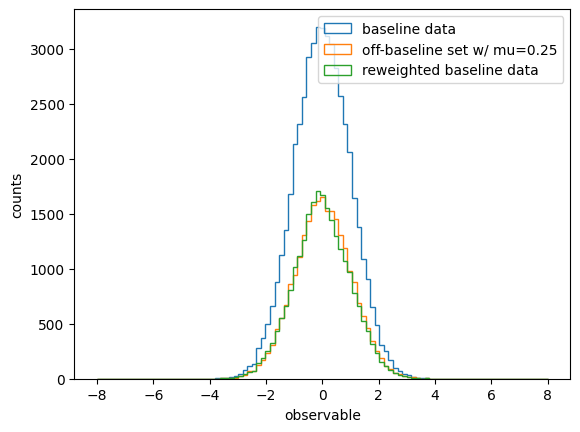

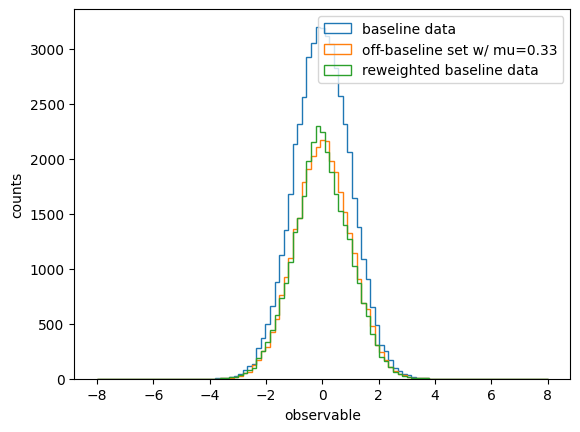

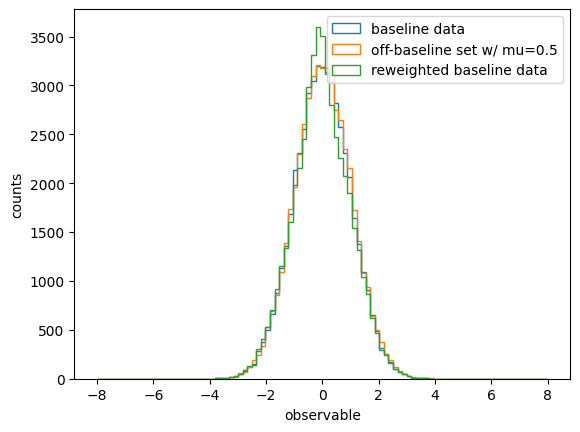

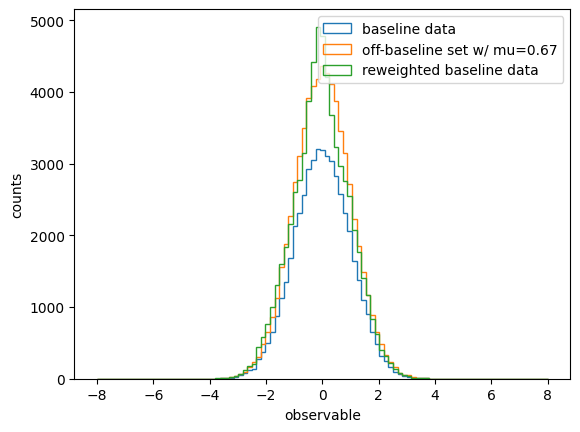

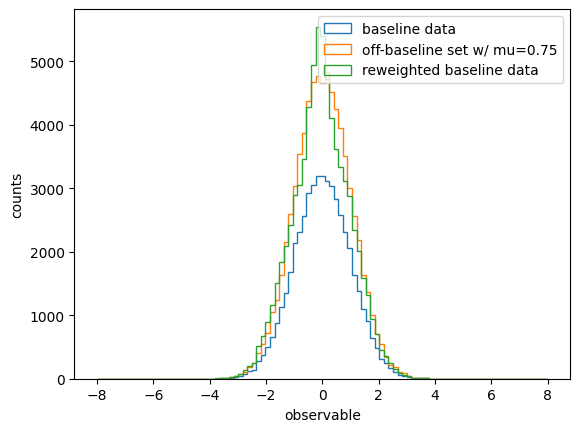

In [135]:
for i,goal_alpha in enumerate(off_baseline_ps):
    reweight = flow.get_shape_weights(baseline_data,jnp.array([base_alpha]),jnp.array([goal_alpha]))
    reweight = yld.ratio([[.5]],[[goal_alpha,]]) * reweight
    fig, ax = plt.subplots()
    bins = jnp.linspace(-8,8,100)
    ax.hist(baseline_data,bins=bins,histtype="step",label="baseline data")
    ax.hist(off_baseline_sets[i],bins=bins,histtype="step", label=f"off-baseline set w/ mu={goal_alpha}")
    ax.hist(baseline_data,bins=bins,histtype="step",weights=reweight,label="reweighted baseline data")
    ax.set_xlabel("observable")
    ax.set_ylabel("counts")
    plt.legend()


In [131]:
yld = YieldModel_Poly(oba,yields,degree=50)

/Users/ojanik/Code/FlowStorm/FlowStorm/yield_model.py:187: RuntimeWarning: overflow encountered in exp
  return np.exp(logN_goal - logN_base)
/Users/ojanik/miniforge3/envs/FlowStorm/lib/python3.12/site-packages/jax/_src/numpy/array_constructors.py:262: RuntimeWarning: overflow encountered in cast
  out = np.asarray(object, dtype=dtype)


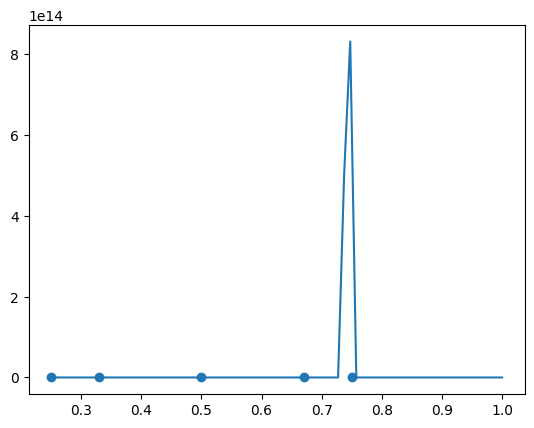

In [132]:
plt.scatter(off_baseline_ps,yields)
xx = jnp.linspace(0,1,100)
yy = jnp.array([yld.ratio([[.5]],[[x]]) for x in xx] )* len(baseline_data)
plt.plot(xx,yy)